# Traffic sign recognition - Nerual Net

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import numpy as np
np.random.seed(123)  # for reproducibility

import tensorflow as tf
print(tf.__version__)

tf.enable_eager_execution()

from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPool2D, MaxPooling2D
from keras import activations

from sklearn import model_selection
from sklearn.utils import shuffle

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from imageio import imread # Need 'Imageio' 'Pillow' packages
import cv2

from math import floor, ceil

import h5py

1.15.2


Using TensorFlow backend.


# Run this if on Colab

In [3]:
# Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

# Unzipping the data
!unzip /content/drive/My\ Drive/German\ traffic\ sign\ dataset.zip #-d path_to_directory /content/German_traffic_sign_dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/My Drive/German traffic sign dataset.zip
replace German traffic sign dataset/GTSRB_Testing/00000.ppm? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## Load data from German traffic sign database

In [4]:
# Use this if local
#main_folder_path = "./German traffic sign dataset"
# Use this if Colab
main_folder_path = "/content/German traffic sign dataset"

train_dataset_path = main_folder_path + "/GTSRB_Training" + "/"

csv_content = [] # One numpy array per folder
                 # Each numpy array x: image y: proprierties

# Iterate over all subfolders to read the CSV file of each class
for i in range(43):
    image_path = train_dataset_path + "{:05.0f}".format(i) + "/"
    f_name = image_path + "GT-" + "{:05.0f}".format(i) + ".csv"
    csv_content.append(np.genfromtxt(f_name, delimiter=';', skip_header=1, dtype=str))
print(csv_content[0][1,:])

['00000_00001.ppm' '30' '30' '5' '5' '25' '25' '0']


In [0]:
# Load the images and respective class

image = []
labels = []

for i in range(43):
    image_class = []
    train_dataset_path = main_folder_path + "/GTSRB_Training" + "/" + "{:05.0f}".format(i) + '/'
    for label_name in enumerate(csv_content[i][:,0]):
        image_class.append(imread(train_dataset_path + label_name[1])[:,:,0]*0.2989+ # Adding image
                           imread(train_dataset_path + label_name[1])[:,:,1]*0.5870+ # with color
                           imread(train_dataset_path + label_name[1])[:,:,2]*0.1140) # adjusted by filtering
    labels.append(i*np.ones(len(image_class))) # Appending image class based on folder
    image.append(image_class)

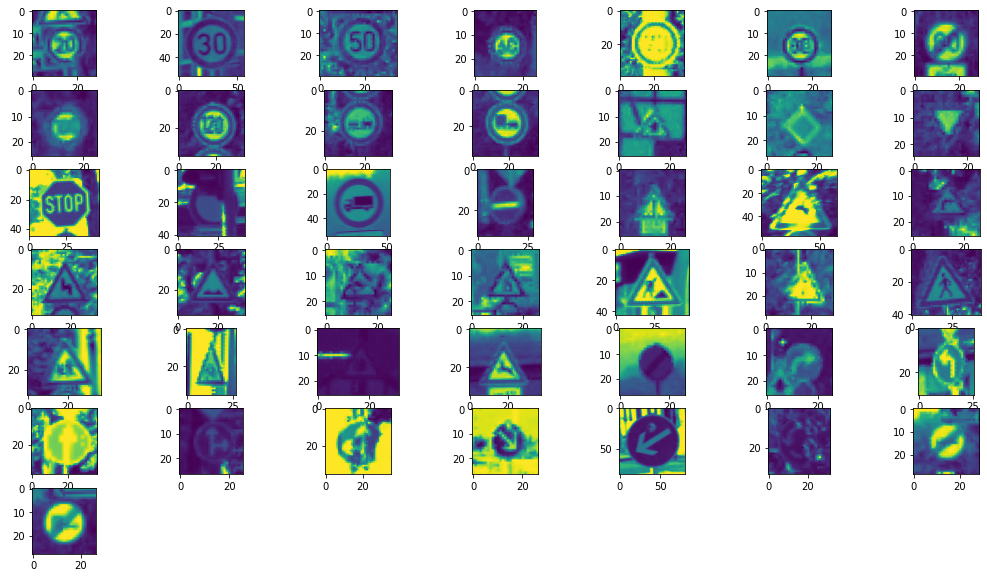

In [6]:
# Print the first image in every class
fig = plt.figure(figsize=(18, 10))
gs = gridspec.GridSpec(nrows=7, ncols=7)

for i in enumerate(image):
    ax0 = fig.add_subplot(gs[i[0]//7, i[0]%7])
    ax0.imshow(i[1][0])
    
plt.show()

<function matplotlib.pyplot.show>

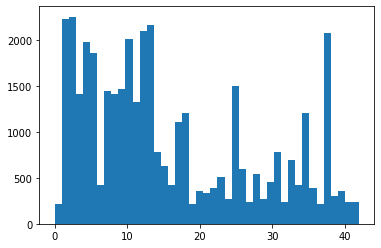

In [7]:
# Histogram of class population
plt.hist(np.concatenate(labels), len(image))
plt.show

## Adapting the images

In [0]:
# Reshape training set
x_size = 32
y_size = 32
img_train = []

for image_set in enumerate(image):
    for image_array in enumerate(image_set[1]):
        # Cutting the image to match the content
        x2 = int(csv_content[image_set[0]][image_array[0], 5]) 
        x1 = int(csv_content[image_set[0]][image_array[0], 3])
        y2 = int(csv_content[image_set[0]][image_array[0], 6]) 
        y1 = int(csv_content[image_set[0]][image_array[0], 4])
        size = max(x2-x1, y2-y1)
        # Padding to have square images
        padded = np.pad(np.asarray(image_array[1][x1:x2, y1:y2]), \
                        ((floor((size-x2+x1)/2), ceil((size-x2+x1)/2)),\
                         (floor((size-y2+y1)/2), ceil((size-y2+y1)/2))))
        # Reshaping the image to match the selected dimension
        reshaped = cv2.resize(padded, (x_size, y_size), interpolation = cv2.INTER_AREA)
        # Copying the image inside the output array
        img_train.append(reshaped)
img_train = np.asarray(img_train)

In [0]:
# Reshaping the train data to have a correct fit input
img_train_rsh = np.reshape(img_train, (img_train.shape[0], img_train.shape[1], img_train.shape[2],1))
labels_flattened = np.concatenate(labels)
x_train, y_train = shuffle(img_train_rsh, labels_flattened)

In [0]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = to_categorical(y_train, len(image))
# Normalizing for better performance
x_train /= 255

# Post training quantization



In [0]:
def rep_data_gen():
    for i in x_train:
        f = np.reshape(i, (1, 32, 32, 1))
        tensor = tf.convert_to_tensor(f, np.float32)
        yield [tensor]

In [12]:
#converter = tf.lite.TFLiteConverter.from_keras_model_file('/content/model_s.h5') 
#converter.optimizations = [tf.lite.Optimize.DEFAULT]
#tfmodel = converter.convert() 

converter = tf.lite.TFLiteConverter.from_keras_model_file('./model_s.h5')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = rep_data_gen
converter.target_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

quant_model = converter.convert()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/tensorflow-1.15.2/python3.6/tensorflow_core/lite/python/lite.py:854: UserWarning: Property target_ops is deprecated, please use target_spec.supported_ops instead.
  "target_spec.supported_ops instead." % name)


## Exporting post-train quantized model

In [13]:
open ("/content/model_pq.tflite" , "wb") .write(quant_model)

111712